# Focus Area 1 — Ground Observations Monitoring &amp; QC
**Core Objective**: To equip NMHS participants with tools for quality-controlling ground station
data and validating it against satellite products, enabling identification of network issues and
building confidence in observational networks.

Require 2 files
- The Metadata file: TAHMO_Metadata.csv
- The TAHMO data file: TAHMO_data.csv

Metadata file format (Columns):
<!DOCTYPE html>
<html>
<head>
    <title>TAHMO Metadata</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Code</th>
            <th>Latitude</th>
            <th>Longitude</th>
        </tr>
        <tr>
            <td>TA00283</td>
            <td>1.2345</td>
            <td>36.7890</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Data file format (Columns): Temperature / Precipitation data for multiple stations
<html>
<head>
    <title>TAHMO Data</title>
</head>
<body>
    <table border="1">
        <tr>
            <th>Date</th>
            <th>TA00283</th>
            <th>TA00284</th>
            <th>TA00285</th>
            <!-- More station codes as needed -->
        </tr>
        <tr>
            <td>2023-01-01</td>
            <td>25.3</td>
            <td>26.1</td>
            <td>24.8</td>
        </tr>
        <!-- More rows as needed -->
    </table>
</html>

Required Dependencies

In [1]:
!git clone https://github.com/kaburia/NOAA-workshop.git
!cd NOAA-workshop && pip install -r requirements.txt

Cloning into 'NOAA-workshop'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 176 (delta 21), reused 4 (delta 2), pack-reused 136 (from 1)
Receiving objects: 100% (176/176), 53.74 MiB | 21.66 MiB/s, done.
Resolving deltas: 100% (86/86), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.9/101.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.3/145.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━

In [2]:
import os
os.chdir('NOAA-workshop')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import ee
import xarray as xr
import numpy as np
from scipy.stats import pearsonr, ttest_rel



import utils

from utils.ground_stations import plot_stations_folium
from utils.helpers import get_region_geojson
from utils.CHIRPS_helpers import get_chirps_pentad_gee
from utils.plotting import plot_xarray_data

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Data Extraction
- Accesssing TAHMO Data and CHIRPS Data

###  Extract TAHMO data using filter-stations

Documentation: https://filter-stations.netlify.app/

A config file is provided with the api keys to access TAHMO Data
```json
{
    "apiKey": "",
    "apiSecret": "",
}

```

In [21]:
import json
from utils.filter_stations import RetrieveData

# Load the config file
with open('/content/config (1).json', 'r') as f:
    config = json.load(f)

# Set the api key and secret
api_key = config['apiKey']
api_secret = config['apiSecret']


# Initialize the class
rd = RetrieveData(apiKey=api_key,
                  apiSecret=api_secret)

East Africa: April-May 2025 floods (Kenya/Rwanda/Uganda), where heavy rains overwhelmed stations.


In [ ]:
# get Kenyan TAHMO weather stations
ke_stations = rd.get_stations_info(countrycode='KE')
print(f"Number of stations in Kenya: {len(ke_stations)}")

# Rwandan Stations
rw_stations = rd.get_stations_info(countrycode='RW')
print(f"Number of stations in Rwanda: {len(rw_stations)}")

# Ugandan Stations
ug_stations = rd.get_stations_info(countrycode='UG')
print(f"Number of stations in Uganda: {len(ug_stations)}")

# Concatenate the East African stations
eac_stations = pd.concat([ke_stations, rw_stations, ug_stations])
print(f"Total number of stations in East Africa: {len(eac_stations)}")

Number of stations in Kenya: 180
Number of stations in Rwanda: 19
Number of stations in Uganda: 61
Total number of stations in East Africa: 260


In [ ]:
# Plot the stations on a map
plot_stations_folium([ke_stations, rw_stations, ug_stations],
                     colors=["blue", "red", "green"])

In [ ]:
# create the data directory/ground for the ground observations
os.makedirs("data/ground", exist_ok=True)

# save this data to be reused later
eac_stations.to_csv("data/ground/eac_stations.csv", index=False)

In [ ]:
# Extract the precipitation data for the East African stations (April -May 2025)
start_date = "2025-04-01"
end_date = "2025-05-31"

eac_precip = rd.multiple_measurements(stations_list=eac_stations['code'].tolist(),
                                     startDate=start_date,
                                     endDate=end_date,
                                     variables=['pr'],
                                     csv_file = "data/ground/eac_precip_apr_may_2025.csv")


Retrieving data for stations:   0%|          | 0/260 [00:00<?, ?it/s]

An error occurred: None: Max retries exceeded with url: /services/measurements/v2/stations/TA00024/measurements/controlled?start=2025-04-01T00%3A00%3A00Z&end=2025-05-31T00%3A00%3A00Z&variable=pr (Caused by None)


### Extracting CHIRPS data

Extract the data from Google Earth engine project
Set up Google Earth Engine Project to access and extract the data


#### Steps to setting up Google Earth Engine Project

1. Get started from the link https://code.earthengine.google.com/register
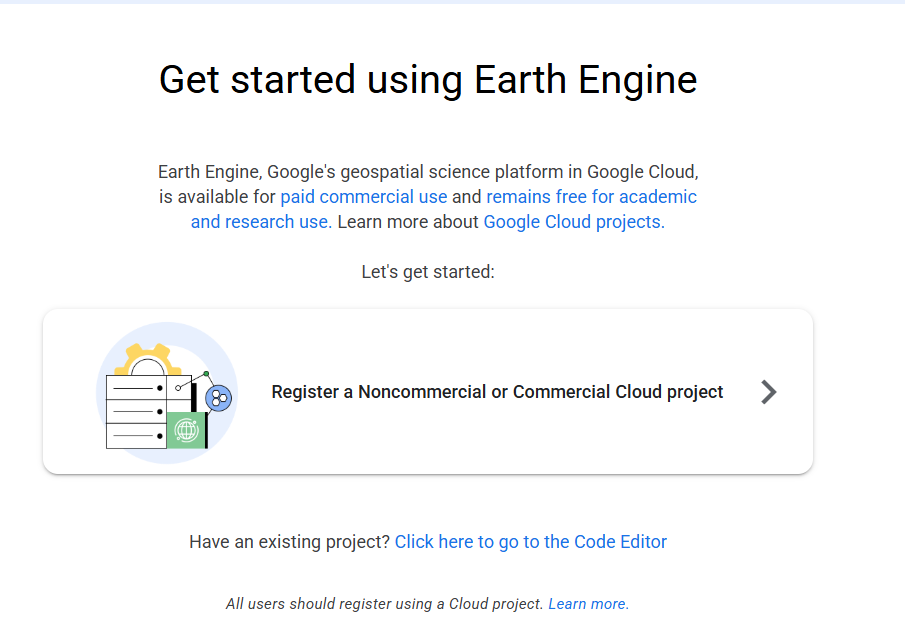

2. 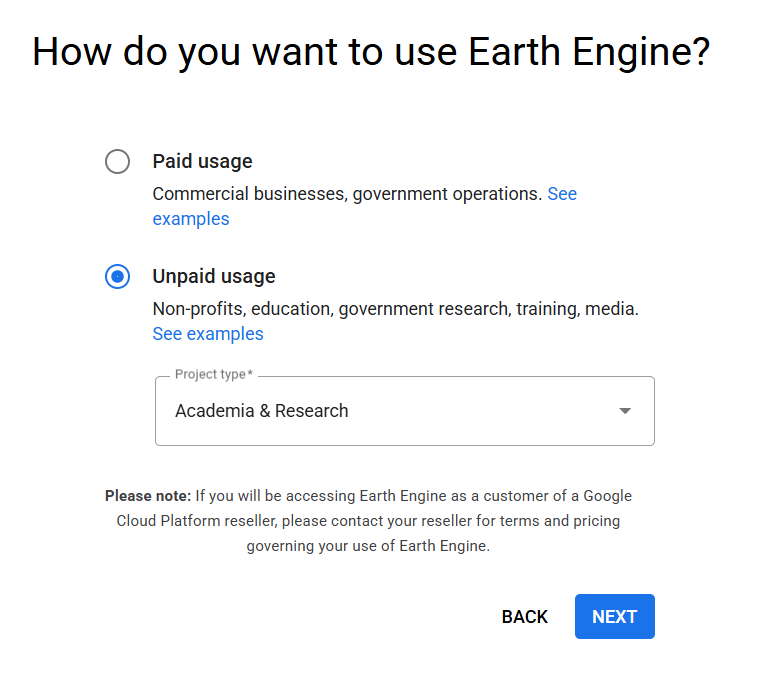

4. 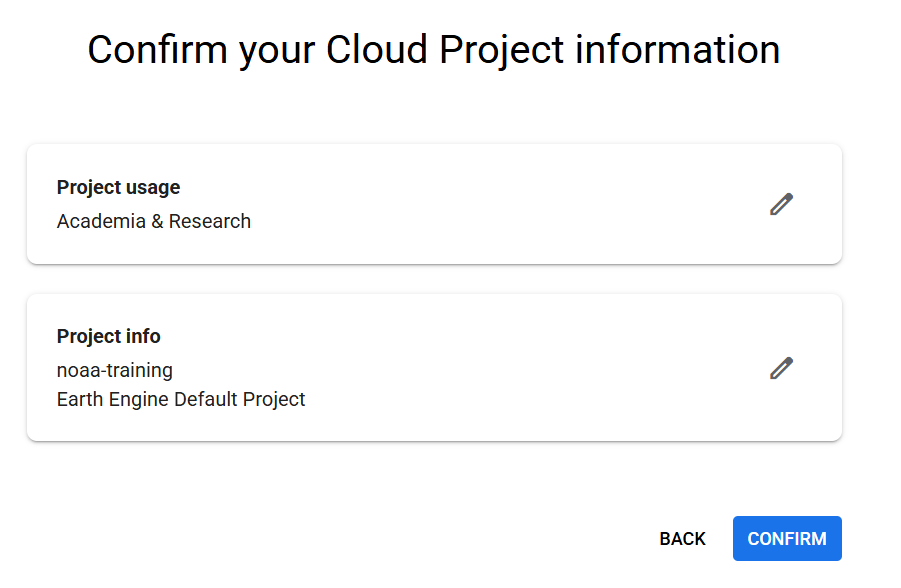

### Extracting CHIRPS Data for the Eat Africa Region (Kenya, Uganda, Rwanda)

Bounding box for the region =
```
[]
```

![image.png](attachment:image.png)

In [ ]:
kenya_region = get_region_geojson('Kenya', config['location_key'])['geometry']['coordinates'][0]
uganda_region = get_region_geojson('Uganda', config['location_key'])['geometry']['coordinates'][0]
rwanda_region = get_region_geojson('Rwanda', config['location_key'])['geometry']['coordinates'][0]

# EAC region to be the sum of this polygon
eac_region = kenya_region + uganda_region + rwanda_region
sorted(eac_region)

[[28.861754, -2.8399383],
 [28.861754, -2.8399383],
 [28.861754, -1.0473752],
 [29.573433, -1.4823178],
 [29.573433, -1.4823178],
 [29.573433, 4.218628],
 [30.8991179, -2.8399383],
 [30.8991179, -1.0473752],
 [33.90982109999999, -4.724299999999999],
 [33.90982109999999, -4.724299999999999],
 [33.90982109999999, 5.033420899999999],
 [35.0330489, -1.4823178],
 [35.0330489, 4.218628],
 [41.9068688, -4.724299999999999],
 [41.9068688, 5.033420899999999]]

In [ ]:

ee.Authenticate()
ee.Initialize(project='leafy-computing-310902')

# Define region of interest (Kenya)
roi = ee.Geometry.Polygon(eac_region)

# Make directory to save satellite data
os.makedirs("data/satellite", exist_ok=True)

# Extract data for 2020
ds = get_chirps_pentad_gee(
    start_date="2025-04-01",
    end_date="2025-05-31",
    region=roi,
    export_path='data/satellite/chirps_pentad_eac.nc'
)

print(ds)

Total number of images: 12

Exporting 1/12: chirps_temp\20250401.tif
Generating URL ...
Please wait ...
Data downloaded to d:\previous-pc\Agent\TAHMO\workshops\NOAA-workshop\chirps_temp\20250401.tif


Exporting 2/12: chirps_temp\20250406.tif
Generating URL ...
Please wait ...
Data downloaded to d:\previous-pc\Agent\TAHMO\workshops\NOAA-workshop\chirps_temp\20250406.tif


Exporting 3/12: chirps_temp\20250411.tif
Generating URL ...
Please wait ...
Data downloaded to d:\previous-pc\Agent\TAHMO\workshops\NOAA-workshop\chirps_temp\20250411.tif


Exporting 4/12: chirps_temp\20250416.tif
Generating URL ...
Please wait ...
Data downloaded to d:\previous-pc\Agent\TAHMO\workshops\NOAA-workshop\chirps_temp\20250416.tif


Exporting 5/12: chirps_temp\20250421.tif
Generating URL ...
Please wait ...
Data downloaded to d:\previous-pc\Agent\TAHMO\workshops\NOAA-workshop\chirps_temp\20250421.tif


Exporting 6/12: chirps_temp\20250426.tif
Generating URL ...
Please wait ...
Data downloaded to d:\previous-

In [ ]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:        (time: 12, y: 198, x: 265)
Coordinates:
  * x              (x) float64 2kB 28.87 28.92 28.97 29.02 ... 41.81 41.86 41.91
  * y              (y) float64 2kB 5.015 4.965 4.916 ... -4.62 -4.669 -4.719
  * time           (time) datetime64[ns] 96B 2025-04-01 ... 2025-05-26
    spatial_ref    int64 8B 0
Data variables:
    precipitation  (time, y, x) float32 3MB dask.array<chunksize=(1, 198, 256), meta=np.ndarray>

In [ ]:
ds = ds.where(ds != -9999)

In [ ]:
ds.precipitation.sel(x=41.5, y=-5.3, method="nearest").to_pandas()

time
2025-04-01   NaN
2025-04-06   NaN
2025-04-11   NaN
2025-04-16   NaN
2025-04-21   NaN
2025-04-26   NaN
2025-05-01   NaN
2025-05-06   NaN
2025-05-11   NaN
2025-05-16   NaN
2025-05-21   NaN
2025-05-26   NaN
Name: precipitation, dtype: float32

In [ ]:
# Select a single time and the (only) band to obtain a 2D array (y, x) for plotting
# pentad_da = ds.band_data.isel(time=0, band=0).squeeze()

# Wrap back into a dataset so the plotting helper expecting a dataset+column works
# pentad_ds = pentad_da.to_dataset(name='band_data')

plot_xarray_data(
    ds,
    column='precipitation',
    fig_title='CHIRPS Pentad Precipitation (mm)\n(Pentad starting {})'.format(str(ds.time.values[0])[:10]),
    polygon=eac_region
)

## Data Processing
1. Range, missing, and flatline detection (≥ N days with unchanged values).
2. Aggregate station rain to pentads to match CHIRPS.
3. Nearest-pixel extraction from CHIRPS and merge with station pentads.
4. Compute per-station Pearson r, RMSE, completeness, outlier rate, paired t-test for
bias.
5. Combine into a 0–100 confidence score and classify (High/Medium/Low).

In [7]:
# Load the CHIRPS and station data
import xarray as xr

eac_data = pd.read_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_precip_apr_may_2025.csv")
# eac metadata
eac_metadata = pd.read_csv("/content/drive/Shareddrives/NOAA-workshop/Datasets/ground/eac_stations.csv")
eac_metadata = eac_metadata[['code', 'location.latitude', 'location.longitude']].rename(columns={'location.latitude': 'lat', 'location.longitude': 'lon'})

# CHIRPS Xarray dataset
chirps_ds = xr.open_dataset("/content/drive/Shareddrives/NOAA-workshop/Datasets/satellite/chirps_pentad_eac.nc")

Format CHIRPS Data

In [8]:
chirps_ds = chirps_ds.where(chirps_ds != -9999)
chirps_ds.precipitation.sel(x=41.5, y=-5.3, method="nearest").to_pandas()

time
2025-04-01   NaN
2025-04-06   NaN
2025-04-11   NaN
2025-04-16   NaN
2025-04-21   NaN
2025-04-26   NaN
2025-05-01   NaN
2025-05-06   NaN
2025-05-11   NaN
2025-05-16   NaN
2025-05-21   NaN
2025-05-26   NaN
Name: precipitation, dtype: float32

Format the TAHMO Data

In [9]:
# Rename Unnamed columns
eac_data = eac_data.rename(columns={"Unnamed: 0": "Date"})
# set Date as datetime
eac_data['Date'] = pd.to_datetime(eac_data['Date'])
# set as index
eac_data = eac_data.set_index('Date')
# localize to None
eac_data.index = eac_data.index.tz_localize(None)

### 1. Range, missing, and flatline detection (≥ N days with unchanged values).

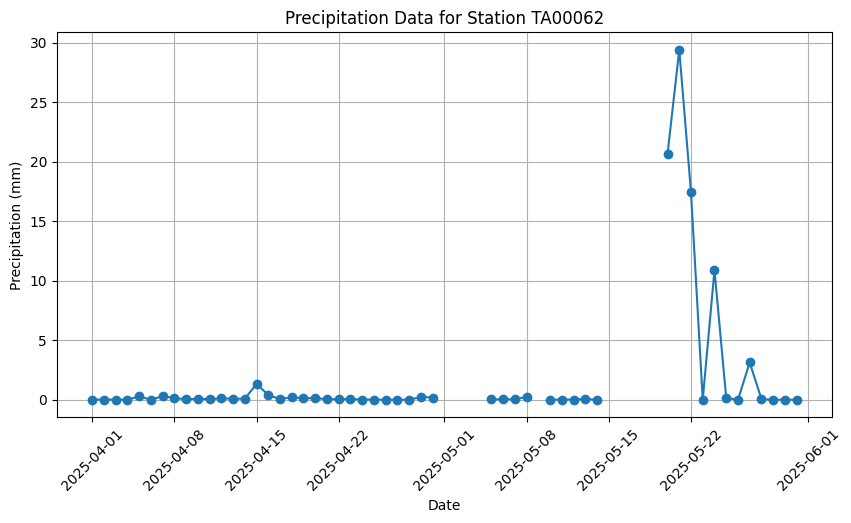

Station Code: TA00062
Data Range: 0.0 mm to 29.398 mm
Number of Records: 61


In [13]:
# Check the range of the data and plot any of the stations randomly
def plot_stations_data_randomly(eac_data):
    import random
    station_codes = eac_data.columns.to_list()
    random_station = random.choice(station_codes)
    station_data = eac_data[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, marker='o')
    plt.title(f'Precipitation Data for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")

plot_stations_data_randomly(eac_data)

Stations with missing data: ['TA00022', 'TA00023', 'TA00024', 'TA00025_S000116', 'TA00025_S002905', 'TA00025_S002904', 'TA00027', 'TA00028', 'TA00031', 'TA00062', 'TA00063', 'TA00065', 'TA00069', 'TA00070_S000768', 'TA00070_S002354', 'TA00074', 'TA00078', 'TA00129', 'TA00133', 'TA00134', 'TA00146', 'TA00147', 'TA00155', 'TA00158', 'TA00166', 'TA00171_S002981', 'TA00173_S000398', 'TA00173_S001569', 'TA00178', 'TA00186', 'TA00188', 'TA00190', 'TA00250', 'TA00258', 'TA00274_S001428', 'TA00274_S002983', 'TA00274_S002982', 'TA00281', 'TA00307', 'TA00320', 'TA00356', 'TA00359', 'TA00378', 'TA00386', 'TA00387', 'TA00389', 'TA00394', 'TA00416', 'TA00441', 'TA00448', 'TA00469', 'TA00569', 'TA00587', 'TA00622', 'TA00623', 'TA00624', 'TA00625', 'TA00626', 'TA00627', 'TA00628', 'TA00629', 'TA00630', 'TA00631', 'TA00632', 'TA00677', 'TA00678', 'TA00765', 'TA00766', 'TA00770', 'TA00771', 'TA00772', 'TA00773', 'TA00774', 'TA00775', 'TA00778', 'TA00807', 'TA00809', 'TA00811', 'TA00824', 'TA00825', 'TA

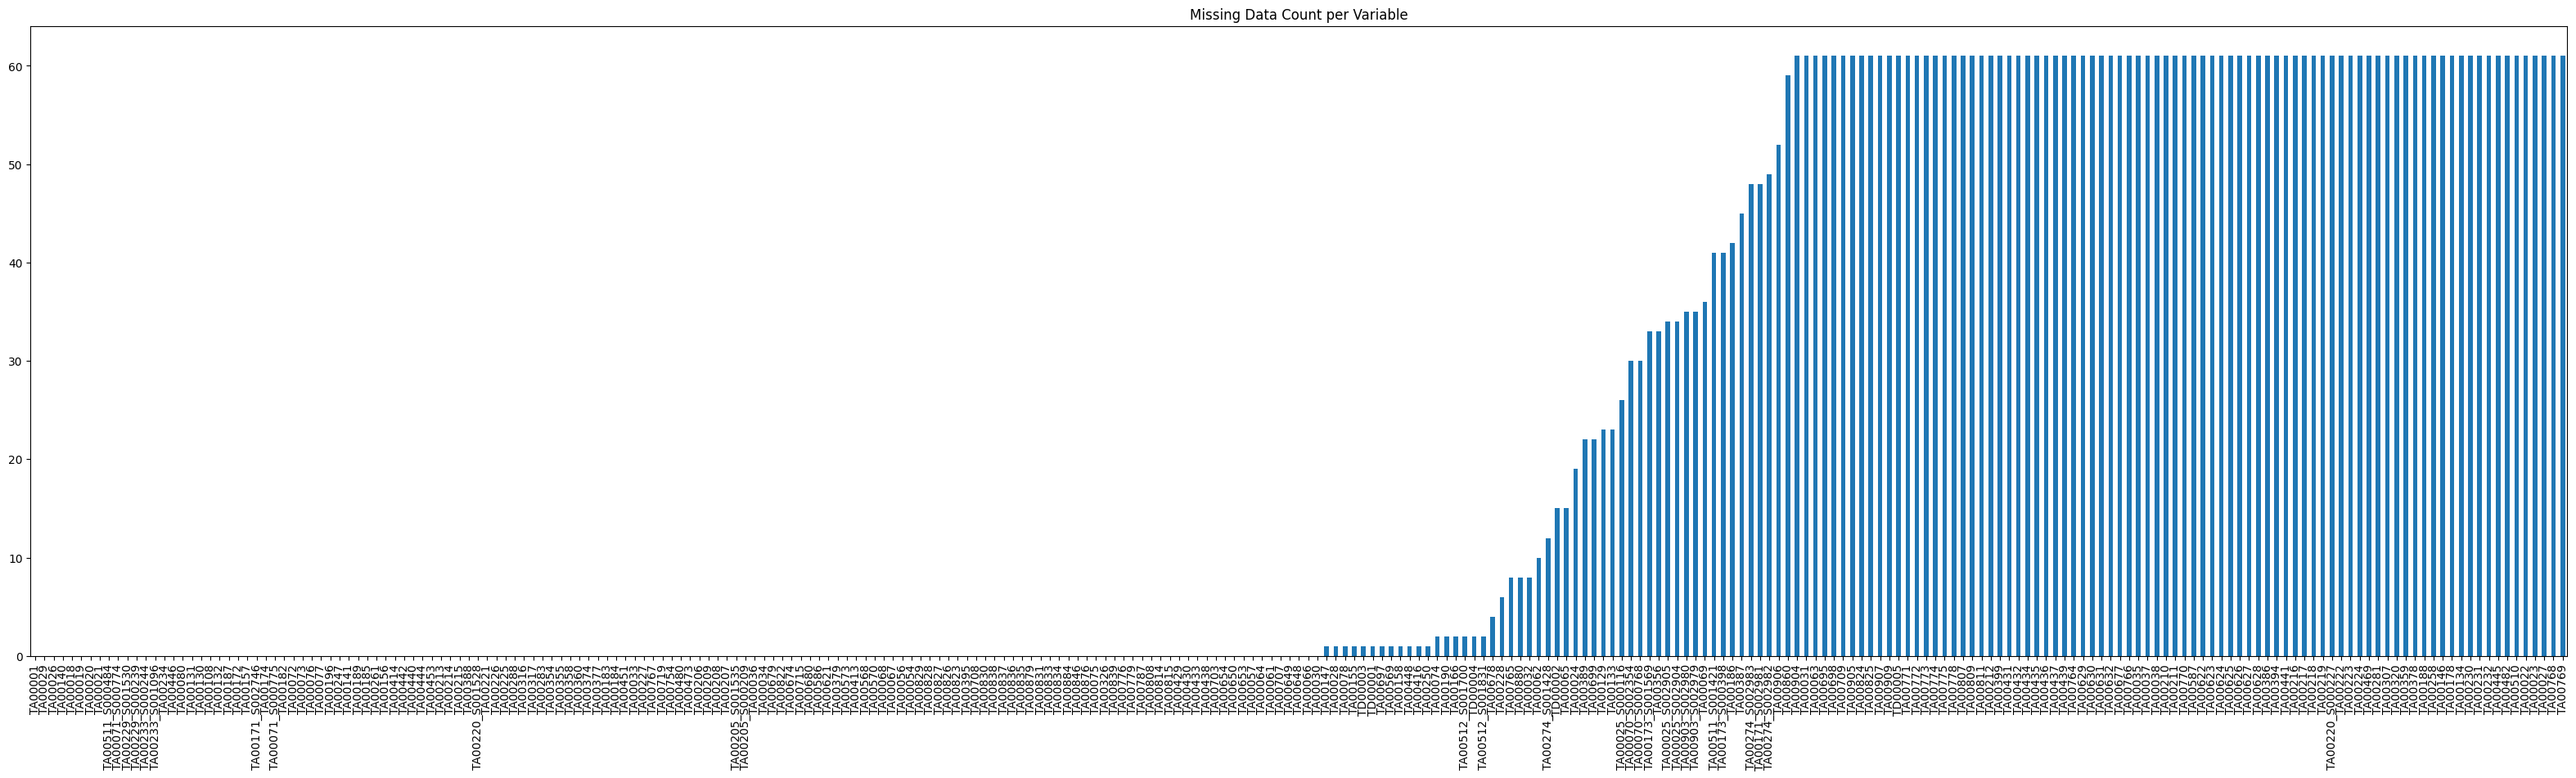

In [14]:
eac_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# Get the stations with missing data
missing_stations = eac_data.columns[eac_data.isna().any()].tolist()
print(f"Stations with missing data: {missing_stations}")


Stations with missing data: ['TA00024', 'TA00025_S000116', 'TA00025_S002905', 'TA00025_S002904', 'TA00028', 'TA00062', 'TA00065', 'TA00069', 'TA00070_S000768', 'TA00070_S002354', 'TA00074', 'TA00078', 'TA00129', 'TA00133', 'TA00147', 'TA00155', 'TA00158', 'TA00166', 'TA00171_S002981', 'TA00173_S000398', 'TA00173_S001569', 'TA00186', 'TA00190', 'TA00250', 'TA00274_S001428', 'TA00274_S002983', 'TA00274_S002982', 'TA00356', 'TA00387', 'TA00389', 'TA00416', 'TA00448', 'TA00569', 'TA00678', 'TA00765', 'TA00880', 'TA00903_S002979', 'TA00903_S002980', 'TD00001', 'TD00002', 'TD00004', 'TA00906', 'TD00003', 'TA00032', 'TA00228', 'TA00511_S001421', 'TA00512_S001831', 'TA00512_S001700', 'TA00697', 'TA00699', 'TA00860']


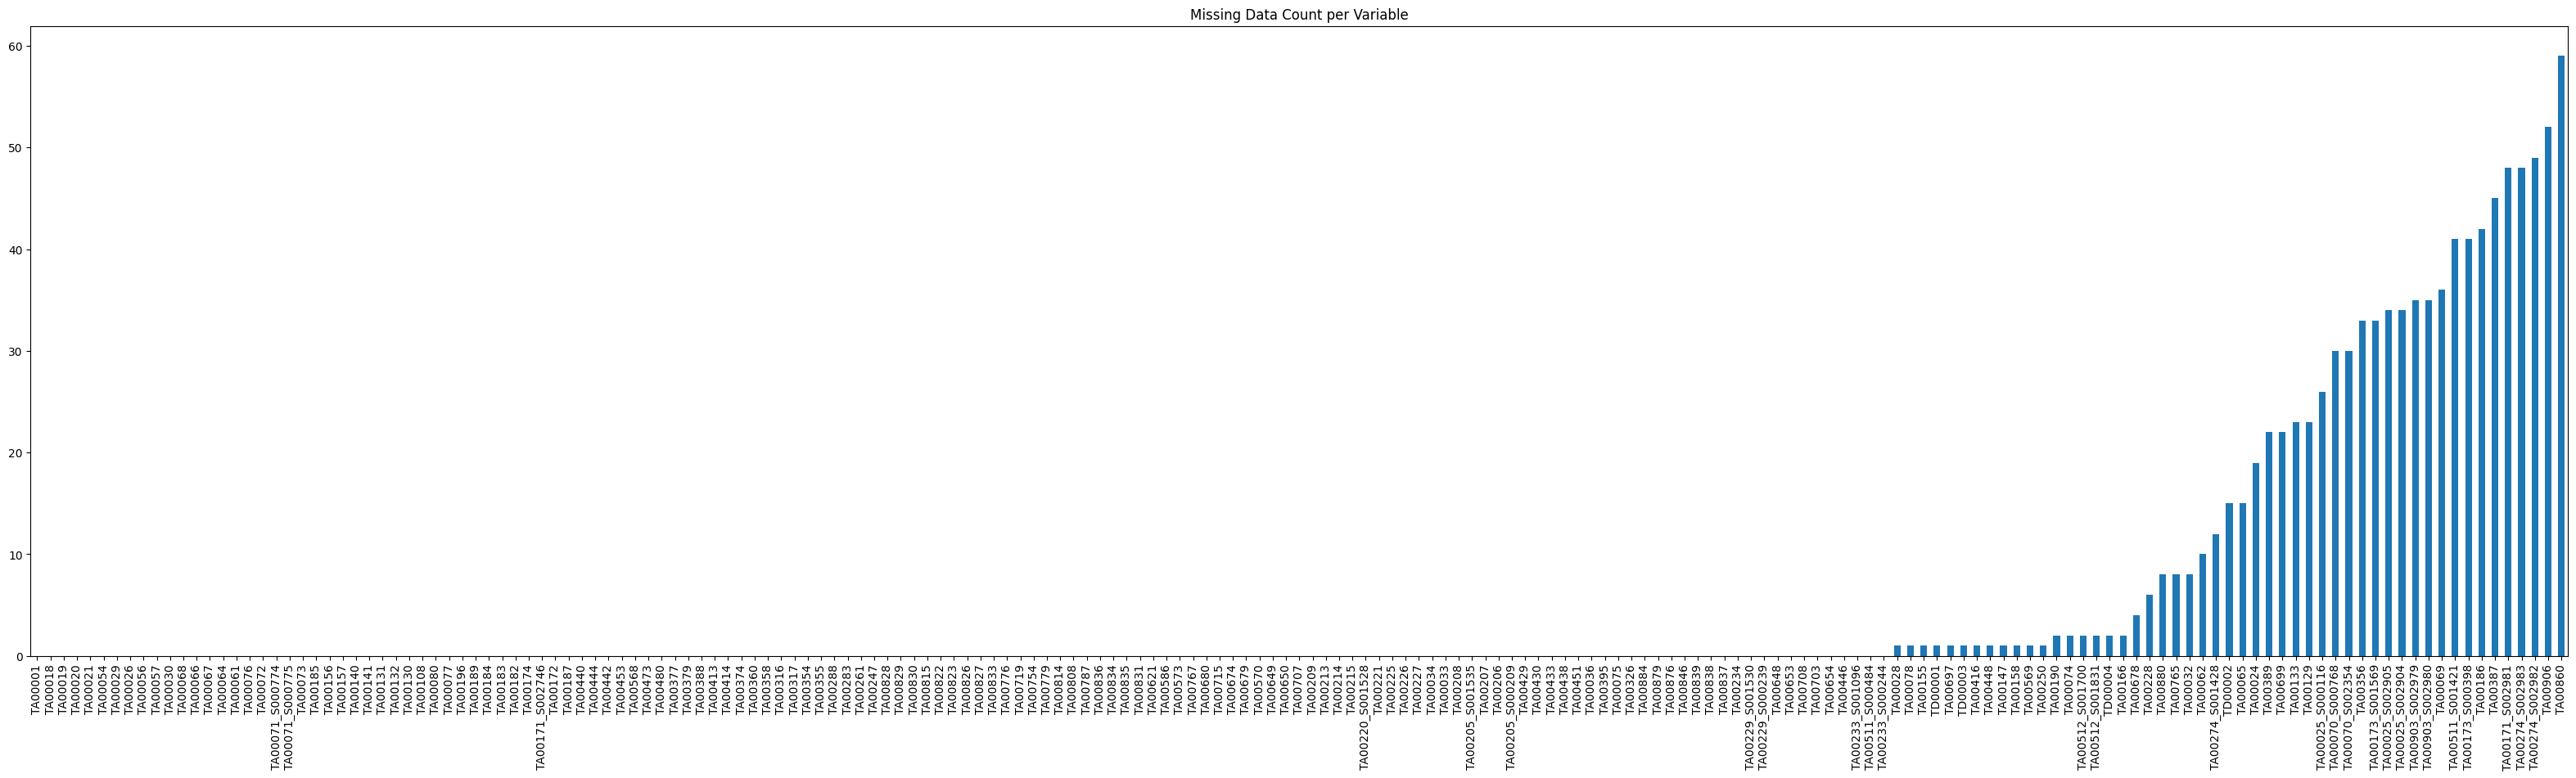

In [15]:
# drop stations with all missing data
eac_data = eac_data.dropna(how='all', axis=1)
eac_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# Get the stations with missing data
missing_stations = eac_data.columns[eac_data.isna().any()].tolist()
print(f"Stations with missing data: {missing_stations}")

Stations with missing data: ['TA00024', 'TA00028', 'TA00062', 'TA00065', 'TA00069', 'TA00074', 'TA00078', 'TA00129', 'TA00133', 'TA00147', 'TA00155', 'TA00158', 'TA00166', 'TA00186', 'TA00190', 'TA00250', 'TA00356', 'TA00387', 'TA00389', 'TA00416', 'TA00448', 'TA00569', 'TA00678', 'TA00765', 'TA00880', 'TD00001', 'TD00002', 'TD00004', 'TA00906', 'TD00003', 'TA00032', 'TA00228', 'TA00697', 'TA00699', 'TA00860']


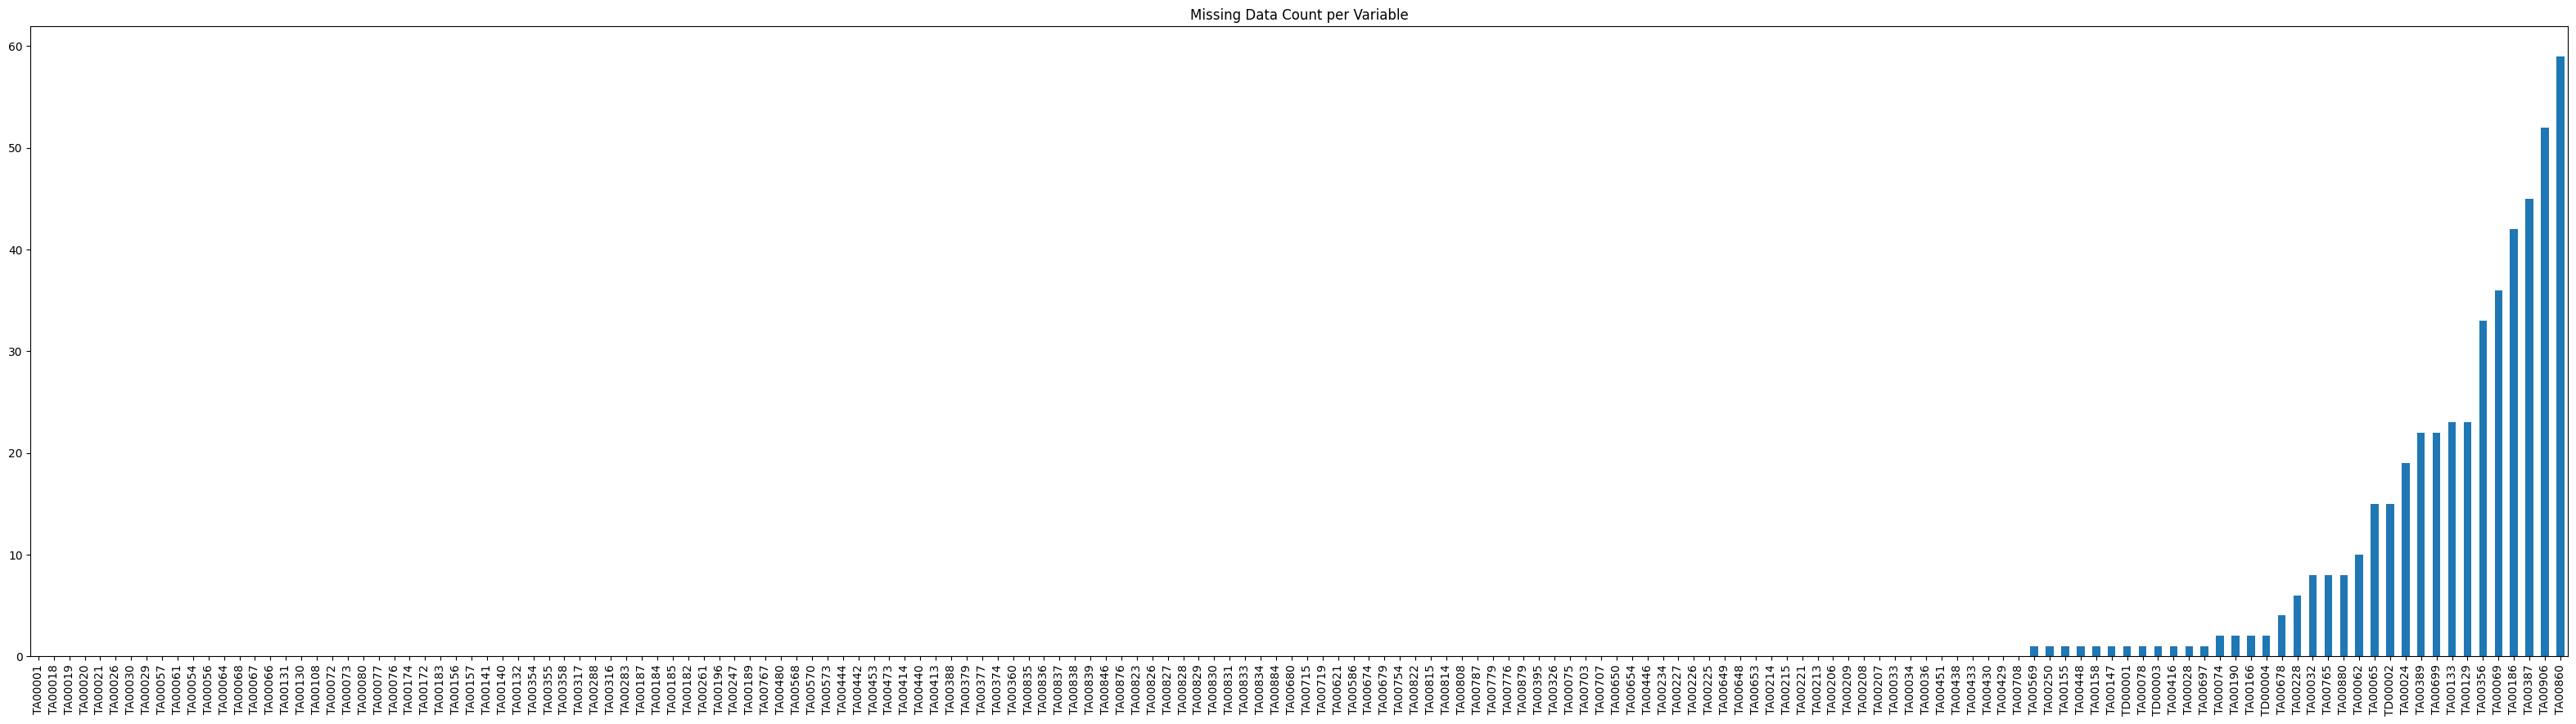

In [16]:
# Drop stations with multiple sensors station_sensor columns
multiple_sensors = [i for i in eac_data.columns if len(i.split('_')) > 1]
eac_data = eac_data.drop(columns=multiple_sensors)
eac_data.isna().sum().sort_values().plot(kind='bar', title='Missing Data Count per Variable', figsize=(40, 10))
# Get the stations with missing data
missing_stations = eac_data.columns[eac_data.isna().any()].tolist()
print(f"Stations with missing data: {missing_stations}")


In [17]:
eac_data.TA00001.rolling(window=5).std()

Date
2025-04-01          NaN
2025-04-02          NaN
2025-04-03          NaN
2025-04-04          NaN
2025-04-05     8.020378
                ...    
2025-05-27    11.962648
2025-05-28    12.015416
2025-05-29    12.620279
2025-05-30     2.295312
2025-05-31     0.200931
Name: TA00001, Length: 61, dtype: float64

In [18]:
# Check for flatlines when values do not change for k days (k=5) with a rolling window
def detect_flatlines(data, window_size=5):
    # store the station and the window in a dictionary
    flatline_info = {}
    for station in data.columns:
        rolling_std = data[station].rolling(window=window_size).std()
        flatline_periods = rolling_std[rolling_std == 0].index.tolist()
        if flatline_periods:
            flatline_info[station] = flatline_periods
    return flatline_info
flatlines = detect_flatlines(eac_data, window_size=5)
print(f"Stations with flatlines: {flatlines}")

Stations with flatlines: {'TA00028': [Timestamp('2025-04-15 00:00:00')], 'TA00030': [Timestamp('2025-04-16 00:00:00'), Timestamp('2025-04-17 00:00:00'), Timestamp('2025-04-18 00:00:00'), Timestamp('2025-05-04 00:00:00')], 'TA00057': [Timestamp('2025-05-01 00:00:00')], 'TA00067': [Timestamp('2025-04-14 00:00:00'), Timestamp('2025-04-15 00:00:00'), Timestamp('2025-04-16 00:00:00'), Timestamp('2025-04-17 00:00:00'), Timestamp('2025-04-18 00:00:00'), Timestamp('2025-04-19 00:00:00'), Timestamp('2025-04-20 00:00:00'), Timestamp('2025-05-16 00:00:00'), Timestamp('2025-05-17 00:00:00'), Timestamp('2025-05-18 00:00:00'), Timestamp('2025-05-19 00:00:00'), Timestamp('2025-05-20 00:00:00'), Timestamp('2025-05-21 00:00:00'), Timestamp('2025-05-22 00:00:00'), Timestamp('2025-05-23 00:00:00'), Timestamp('2025-05-24 00:00:00'), Timestamp('2025-05-25 00:00:00'), Timestamp('2025-05-26 00:00:00'), Timestamp('2025-05-27 00:00:00'), Timestamp('2025-05-28 00:00:00'), Timestamp('2025-05-29 00:00:00'), Times

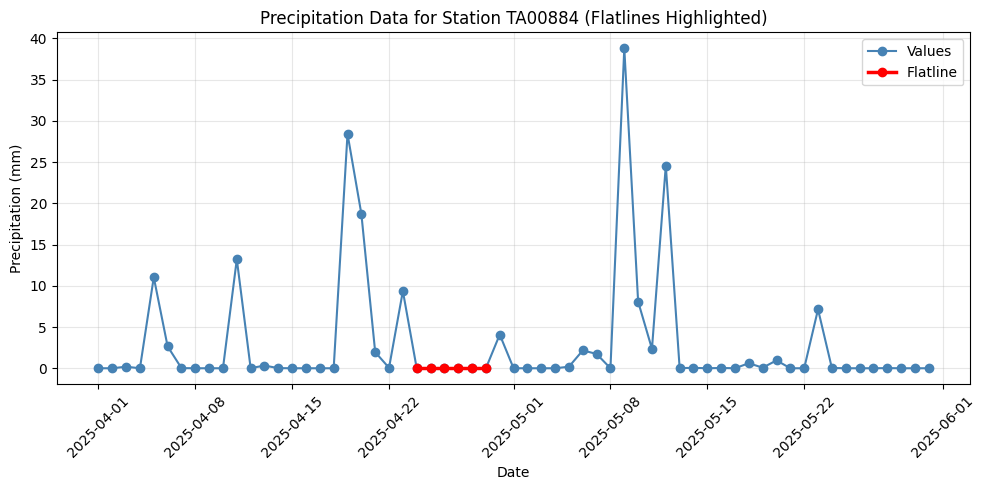

Station Code: TA00884
Data Range: 0.0 mm to 38.779 mm
Number of Records: 61
Flatline window end timestamps (window=5):
  - 2025-04-28 00:00:00
  - 2025-04-29 00:00:00


In [19]:
# plot the flatline stations highlighting flatline periods in red
def plot_flatline_stations(data, flatline_info, window_size=5, random=True):
    import random

    if not flatline_info:
        print("No flatlines detected.")
        return

    station = random.choice(list(flatline_info.keys())) if random else list(flatline_info.keys())[0]
    station_data = data[station].copy()

    # Build a mask for flatline periods
    mask = pd.Series(False, index=station_data.index)
    periods = flatline_info[station]
    for end_ts in periods:
        if end_ts in station_data.index:
            # mark the window contributing to zero std
            start_pos = station_data.index.get_loc(end_ts) - window_size + 1
            if start_pos >= 0:
                flat_index = station_data.index[start_pos: station_data.index.get_loc(end_ts) + 1]
                mask.loc[flat_index] = True

    plt.figure(figsize=(10, 5))
    plt.plot(station_data.index, station_data.values, color='steelblue', marker='o', label='Values')

    # Overlay flatline segments in red
    if mask.any():
        flat_series = station_data[mask]
        # To keep contiguous red segments joined, plot as line over masked points sorted
        plt.plot(flat_series.index, flat_series.values, color='red', linewidth=2.5, marker='o', label='Flatline')

    plt.title(f'Precipitation Data for Station {station} (Flatlines Highlighted)')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Station Code: {station}")
    print(f"Data Range: {station_data.min()} mm to {station_data.max()} mm")
    print(f"Number of Records: {len(station_data)}")
    if periods:
        print(f"Flatline window end timestamps (window={window_size}):")
        for ts in periods:
            print(f"  - {ts}")
    else:
        print("No flatline periods for this station.")

plot_flatline_stations(eac_data, flatlines, window_size=5, random=True)

### 2. Aggregate station rain to pentads to match CHIRPS.

In [22]:
eac_pentad = rd.aggregate_variables(eac_data, freq='5D', method='sum')[:-1]
eac_pentad

TA00001  TA00018  TA00019  TA00020  TA00021  TA00024  TA00026  \
Date                                                                        
2025-04-01   21.751    0.816    4.233    2.499    8.926    7.297   17.995   
2025-04-06   31.766    0.901    2.856    0.782    4.611   23.184    4.709   
2025-04-11   57.699    0.697    0.850    0.510   12.555    5.118    8.228   
2025-04-16   13.474    0.663    0.595    3.179   45.233   63.021    0.204   
2025-04-21   14.913    0.527    0.425    0.748    2.618   29.963    1.649   
2025-04-26    6.067    4.186    1.190    3.625   24.215    2.928   19.524   
2025-05-01   44.566   10.423   11.682    0.986   48.150    4.745   12.759   
2025-05-06  111.336   41.760    1.309   47.264   44.792    2.432  100.671   
2025-05-11   54.746   23.217    0.816   10.338    9.577    0.034   21.103   
2025-05-16   62.693   42.222    3.332    3.539   21.027      NaN   12.855   
2025-05-21   71.406   60.807    4.539    0.051   43.525      NaN   43.710   
2025-05-26    6.480   51.186    1.190    0.153    9.785    0.000   37.100   

            TA00028  TA00029  TA00030  ...  TA00649  TA00650  TA00653  \
Date                                   ...                              
2025-04-01    1.071   93.252    0.136  ...   37.150   46.680   88.510   
2025-04-06    3.009   22.775    0.476  ...   45.363   48.070   43.149   
2025-04-11    0.000   56.301    0.034  ...   31.394   17.637    0.119   
2025-04-16    0.340   56.294    0.238  ...   13.555   11.750   10.295   
2025-04-21    0.289   16.986    0.170  ...   26.294   28.508   11.916   
2025-04-26    4.641   18.677    0.068  ...    5.630    7.248    2.482   
2025-05-01   11.510   17.299    0.255  ...   14.235    9.419   15.015   
2025-05-06    4.434   62.523   10.836  ...   60.190   19.212   32.230   
2025-05-11    0.272   38.788   13.337  ...    7.008    1.888    5.954   
2025-05-16    4.014    2.992    2.416  ...    3.434    4.337    2.553   
2025-05-21    4.611   12.932   10.375  ...   23.593   17.484   54.096   
2025-05-26    1.037    8.145    0.051  ...    0.782    0.901    4.914   

            TA00654  TA00697  TA00699  TA00703  TA00707  TA00708  TA00860  
Date                                                                       
2025-04-01   54.947   74.373    3.434    7.378   20.707    0.000    0.017  
2025-04-06   39.129    5.323    0.170    9.503   38.805    0.000      NaN  
2025-04-11   62.953   20.034      NaN   25.649   70.338    0.000      NaN  
2025-04-16   10.628   10.477      NaN    5.712    0.221    0.000      NaN  
2025-04-21    2.176   18.528      NaN   13.889   12.846    0.000      NaN  
2025-04-26   17.541   33.874      NaN    4.029    0.680    0.000      NaN  
2025-05-01    8.515   20.606    0.459   14.038   23.596    0.000      NaN  
2025-05-06   33.022    4.134    0.272   28.543   88.859    0.000      NaN  
2025-05-11   10.184    0.170    0.204    4.352    3.334    0.000      NaN  
2025-05-16   13.198    0.017    4.530   14.454    9.632    0.000      NaN  
2025-05-21   41.672    0.000    7.748    0.357    0.391   10.387      NaN  
2025-05-26    0.833    0.000    5.414    3.128   21.745  116.178      NaN  

[12 rows x 164 columns]

### 3. Nearest-pixel extraction from CHIRPS and merge with station pentads.

In [23]:
# filter to the required stations
req_stations = eac_pentad.columns.tolist()

eac_metadata = eac_metadata[eac_metadata['code'].isin(req_stations)]

In [24]:
# Build the dataset from the station coordinates by selecting
def build_chirps_from_stations(chirps_ds, stations_metadata):
    import xarray as xr
    import pandas as pd

    all_stations_data = {}
    for _, row in stations_metadata.iterrows():
        station_code = row['code']
        lat = row['lat']
        lon = row['lon']

        # Extract nearest pixel data
        station_da = chirps_ds.precipitation.sel(x=lon, y=lat, method="nearest")
        station_df = station_da.to_dataframe().rename(columns={'precipitation': station_code})

        all_stations_data[station_code] = station_df[station_code]

    # Combine all stations into a single DataFrame
    combined_df = pd.DataFrame(all_stations_data)
    return combined_df

In [25]:
chirps_stations = build_chirps_from_stations(chirps_ds, eac_metadata)
chirps_stations

TA00001    TA00018    TA00019    TA00020    TA00021    TA00024  \
time                                                                           
2025-04-01  22.675671  21.486406  17.029030  32.880123  11.923936  26.419672   
2025-04-06  39.152828  35.857357  34.146309  44.188004  18.160852  60.622345   
2025-04-11  55.369488  44.729008  38.641399  21.541342  56.705231  26.075041   
2025-04-16  70.299644  85.723030  46.514614  31.004107  45.457085  30.143660   
2025-04-21  14.200469  43.154476  23.613579  34.441605  19.487366  40.287651   
2025-04-26  29.588150  26.339457  15.584357  16.319296  10.260560  21.504368   
2025-05-01  38.841564  49.871922  41.175125   5.011575  33.946831  14.609083   
2025-05-06  45.314613  76.498558  81.889191  20.625410  70.281509  30.026611   
2025-05-11  60.656330  75.472321  54.697277  40.382950  24.039356  26.216661   
2025-05-16  40.707409  12.068048  14.211968   2.690459  16.401772   5.273005   
2025-05-21  72.650322  46.028168  36.385448   7.141160  41.055923  12.492900   
2025-05-26  65.803024  45.441681  31.117989   4.197843  23.889994   8.606000   

              TA00026    TA00028    TA00029    TA00030  ...    TA00649  \
time                                                    ...              
2025-04-01  12.158224  10.630191  48.504349  33.998730  ...  28.570305   
2025-04-06  24.823616  32.016052  81.527077  50.560883  ...  29.936232   
2025-04-11  57.467075  28.991957  23.693300  30.796175  ...  17.460833   
2025-04-16  26.290825  15.032025  29.051308  16.714273  ...  53.619514   
2025-04-21  30.019978  25.359011  49.638817  36.996674  ...  18.861164   
2025-04-26  24.265987  11.480598  26.986778  13.306293  ...   7.919460   
2025-05-01  35.636139  41.578083  29.030819  21.924067  ...  37.225311   
2025-05-06  37.633018  15.966193  60.908482  26.309328  ...  50.282780   
2025-05-11  18.308039  10.138810  42.430737  25.114698  ...  20.881123   
2025-05-16  13.214114   6.901505  20.924311   5.535652  ...   4.536842   
2025-05-21  40.649399   5.589628  23.174173  10.408379  ...  26.940241   
2025-05-26  16.683456   8.644426  17.845905  11.448493  ...  23.758419   

              TA00650    TA00653    TA00654    TA00697    TA00699    TA00703  \
time                                                                           
2025-04-01  28.570305  32.811386  29.994921  35.172180  49.726765  28.429964   
2025-04-06  29.936232  32.988098  30.910355  39.881538  43.305153  28.813520   
2025-04-11  17.460833  21.112495  15.421872  21.881319  28.876390  15.007889   
2025-04-16  53.619514  55.867092  51.854469  27.247355  33.602440  30.664532   
2025-04-21  18.861164  22.962360  18.946188  38.578007  44.768723  27.130585   
2025-04-26   7.919460  10.186317   7.906303  17.815998  22.444920   9.802580   
2025-05-01  37.225311  40.923279  36.889732  25.346865  24.919157  28.130732   
2025-05-06  50.282780  56.763718  52.112782  81.755234  84.331596  42.647503   
2025-05-11  20.881123  19.274054  21.247023  24.076471  13.265215  11.447788   
2025-05-16   4.536842   7.229379   4.272478  16.945993  20.825525  12.685871   
2025-05-21  26.940241  30.464508  27.317127  15.448914   8.529984   9.857416   
2025-05-26  23.758419  34.734577  21.647949  15.244626  21.122538  30.980154   

              TA00707    TA00708    TA00860  
time                                         
2025-04-01  24.434956  28.682037  16.288174  
2025-04-06  19.339632  28.227999  41.130142  
2025-04-11  11.521128  18.472502  22.688213  
2025-04-16  22.488997  31.619755  42.014038  
2025-04-21  20.991827  34.808765   3.964390  
2025-04-26   8.795258  10.454839   7.130330  
2025-05-01  25.880333  22.173702  32.907017  
2025-05-06  29.529318  33.794792  18.578663  
2025-05-11  14.448731   8.958232  13.458889  
2025-05-16  10.807283   8.831873  10.060316  
2025-05-21   8.665929   7.934868  21.982248  
2025-05-26  23.722588  18.496939  10.578348  

[12 rows x 164 columns]

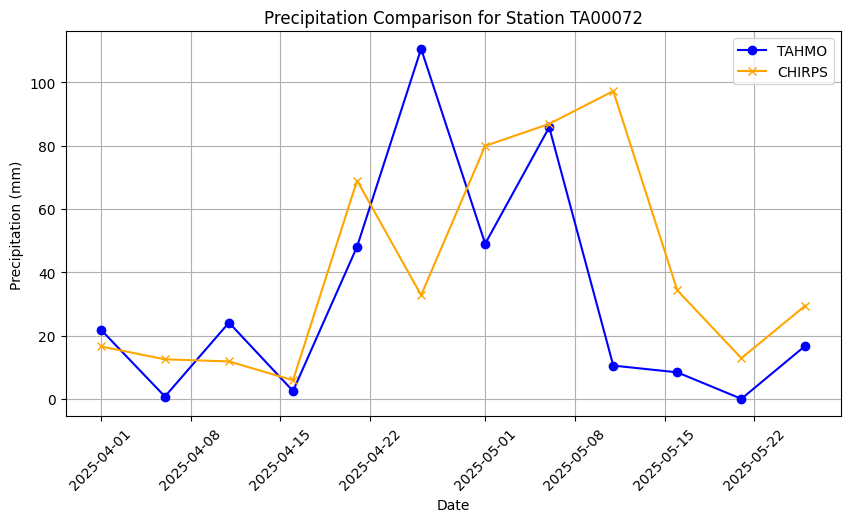

Station Code: TA00072
TAHMO Data Range: 0.0 mm to 110.578 mm
CHIRPS Data Range: 5.881016254425049 mm to 97.22811889648438 mm
Number of TAHMO Records: 12
Number of CHIRPS Records: 12


In [26]:
# Plot the CHIRPS data and TAHMO equivalents for a random station
def plot_chirps_vs_tahmo_randomly(eac_pentad, chirps_stations):
    import random
    station_codes = eac_pentad.columns.intersection(chirps_stations.columns).tolist()
    if not station_codes:
        print("No common stations between EAC pentad data and CHIRPS data.")
        return

    random_station = random.choice(station_codes)

    tahmo_data = eac_pentad[random_station]
    chirps_data = chirps_stations[random_station]

    plt.figure(figsize=(10, 5))
    plt.plot(tahmo_data.index, tahmo_data.values, marker='o', label='TAHMO', color='blue')
    plt.plot(chirps_data.index, chirps_data.values, marker='x', label='CHIRPS', color='orange')
    plt.title(f'Precipitation Comparison for Station {random_station}')
    plt.xlabel('Date')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"Station Code: {random_station}")
    print(f"TAHMO Data Range: {tahmo_data.min()} mm to {tahmo_data.max()} mm")
    print(f"CHIRPS Data Range: {chirps_data.min()} mm to {chirps_data.max()} mm")
    print(f"Number of TAHMO Records: {len(tahmo_data)}")
    print(f"Number of CHIRPS Records: {len(chirps_data)}")
plot_chirps_vs_tahmo_randomly(eac_pentad, chirps_stations)

### 4. Compute per-station Pearson r, RMSE, completeness, outlier rate, paired t-test for bias.

In [27]:
eac_pentad.columns == chirps_stations.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [28]:
# RMSE
def rmse(a,b):
    a = np.asarray(a); b = np.asarray(b)
    return float(np.sqrt(np.nanmean((a-b)**2)))

'''
1. Compute the RMSE
2. Compute the Pearson correlation coefficient
3. Compute the ttest for bias
    bias significance (p<0.05) ['Significant' if p_val < 0.05 else 'Not Significant']
4. Compute completeness (% of non-missing values)
        completeness = 1 - g['station_pentad'].isna().mean()
        outlier_rate = (g['station_pentad']<0).mean()
5. confidence_score = 100*(0.4*completeness + 0.4*np.nan_to_num(r, nan=0) + 0.2*(1-outlier_rate))
'''

"\n1. Compute the RMSE\n2. Compute the Pearson correlation coefficient\n3. Compute the ttest for bias\n    bias significance (p<0.05) ['Significant' if p_val < 0.05 else 'Not Significant']\n4. Compute completeness (% of non-missing values) \n        completeness = 1 - g['station_pentad'].isna().mean()\n        outlier_rate = (g['station_pentad']<0).mean()\n5. confidence_score = 100*(0.4*completeness + 0.4*np.nan_to_num(r, nan=0) + 0.2*(1-outlier_rate))\n"

In [ ]:
# Suggest to the formla on calculating confidence scores to subtract rmse

In [29]:
# compute station scores
def compute_station_scores(eac_pentad, chirps_stations): # returns a dataframe of scores 'station_id','confidence_score','pearson_r','rmse','bias_signif'
    # get the union stations
    stations = eac_pentad.columns.intersection(chirps_stations.columns)
    scores = []
    for station in stations:
        obs = eac_pentad[station]
        sim = chirps_stations[station]

        # Compute metrics
        r, _ = pearsonr(obs, sim)
        error = rmse(obs, sim)
        t_stat, p_val = ttest_rel(obs, sim)
        bias_signif = 'Significant' if p_val < 0.05 else 'Not Significant'
        completeness = 1 - obs.isna().mean()
        outlier_rate = (obs < 0).mean()
        confidence_score = 100 * (0.4 * completeness + 0.4 * np.nan_to_num(r, nan=0) + 0.2 * (1 - outlier_rate))
        scores.append(
            {
                'station_id': station,
                'confidence_score': confidence_score,
                'pearson_r': r,
                'rmse': error,
                'bias_signif': bias_signif,
                'completeness': completeness,
                'outlier_rate': outlier_rate
            }
        )
    scores_df = pd.DataFrame(scores)
    return scores_df

In [30]:
station_scores = compute_station_scores(eac_pentad, chirps_stations)

In [31]:
station_scores.sort_values(by='rmse', ascending=True).head(10)


station_id  confidence_score  pearson_r       rmse      bias_signif  \
61     TA00355         60.000000        NaN   5.753097      Significant   
78     TA00453         74.173653   0.354341   6.484148  Not Significant   
60     TA00354         66.058024   0.151451   8.326034  Not Significant   
80     TA00480         89.524917   0.738123   8.606878  Not Significant   
39     TA00157         91.007224   0.775181   9.388319  Not Significant   
62     TA00356         40.000000        NaN  10.329307  Not Significant   
139    TA00206         85.059131   0.626478  10.707677      Significant   
109    TA00831         94.618467   0.865462  10.803124      Significant   
53     TA00247         77.848937   0.446223  11.599731  Not Significant   
49     TA00187         94.789766   0.869744  12.572289  Not Significant   

     completeness  outlier_rate  
61            1.0           0.0  
78            1.0           0.0  
60            1.0           0.0  
80            1.0           0.0  
39            1.0           0.0  
62            0.5           0.0  
139           1.0           0.0  
109           1.0           0.0  
53            1.0           0.0  
49            1.0           0.0

In [32]:
station_scores.sort_values(by='rmse', ascending=True).iloc[10:20]


station_id  confidence_score  pearson_r       rmse      bias_signif  \
43     TA00174         82.816862   0.570422  12.726819  Not Significant   
30     TA00130         91.343777   0.783594  13.080172  Not Significant   
66     TA00377         87.248913   0.681223  13.449691      Significant   
98     TA00787         93.166823   0.829171  13.739472      Significant   
140    TA00207         66.416430   0.160411  14.062416  Not Significant   
131    TA00438         84.211569   0.605289  14.753311  Not Significant   
22     TA00073         67.236587   0.180915  14.820093      Significant   
121    TA00884         84.633160   0.615829  15.121276  Not Significant   
107    TA00829         83.878731   0.596968  15.603829  Not Significant   
76     TA00444         89.293399   0.732335  15.796855      Significant   

     completeness  outlier_rate  
43            1.0           0.0  
30            1.0           0.0  
66            1.0           0.0  
98            1.0           0.0  
140           1.0           0.0  
131           1.0           0.0  
22            1.0           0.0  
121           1.0           0.0  
107           1.0           0.0  
76            1.0           0.0

In [33]:
# to the confidence scores subtract the rmse
station_scores['adjusted_confidence_score'] = station_scores['confidence_score'] - station_scores['rmse']
station_scores.sort_values(by='adjusted_confidence_score', ascending=False).head(20)

station_id  confidence_score  pearson_r       rmse      bias_signif  \
109    TA00831         94.618467   0.865462  10.803124      Significant   
49     TA00187         94.789766   0.869744  12.572289  Not Significant   
39     TA00157         91.007224   0.775181   9.388319  Not Significant   
63     TA00358         97.206761   0.930169  16.067460      Significant   
80     TA00480         89.524917   0.738123   8.606878  Not Significant   
98     TA00787         93.166823   0.829171  13.739472      Significant   
30     TA00130         91.343777   0.783594  13.080172  Not Significant   
38     TA00156         93.158464   0.828962  17.234239      Significant   
148    TA00226         92.446140   0.811153  17.068467  Not Significant   
139    TA00206         85.059131   0.626478  10.707677      Significant   
66     TA00377         87.248913   0.681223  13.449691      Significant   
76     TA00444         89.293399   0.732335  15.796855      Significant   
32     TA00132         89.770249   0.744256  16.931840  Not Significant   
99     TA00808         92.768860   0.819221  19.950135  Not Significant   
10     TA00054         89.116427   0.727911  17.228612  Not Significant   
116    TA00839         87.105027   0.677626  16.534972  Not Significant   
28     TA00108         94.806537   0.870163  24.647963      Significant   
43     TA00174         82.816862   0.570422  12.726819  Not Significant   
121    TA00884         84.633160   0.615829  15.121276  Not Significant   
131    TA00438         84.211569   0.605289  14.753311  Not Significant   

     completeness  outlier_rate  adjusted_confidence_score  
109           1.0           0.0                  83.815343  
49            1.0           0.0                  82.217477  
39            1.0           0.0                  81.618905  
63            1.0           0.0                  81.139302  
80            1.0           0.0                  80.918039  
98            1.0           0.0                  79.427351  
30            1.0           0.0                  78.263606  
38            1.0           0.0                  75.924225  
148           1.0           0.0                  75.377673  
139           1.0           0.0                  74.351454  
66            1.0           0.0                  73.799222  
76            1.0           0.0                  73.496544  
32            1.0           0.0                  72.838408  
99            1.0           0.0                  72.818725  
10            1.0           0.0                  71.887814  
116           1.0           0.0                  70.570055  
28            1.0           0.0                  70.158574  
43            1.0           0.0                  70.090043  
121           1.0           0.0                  69.511884  
131           1.0           0.0                  69.458258

In [34]:
# save the stations with the confidence scores
station_scores.to_csv('/content/drive/Shareddrives/NOAA-workshop/Datasets/station_scores.csv', index=False)

In [ ]:
def plot_station_vs_chirps_and_confidence(
    station_pentad_df,
    chirps_pentad_df,
    station_scores_df,
    metadata_df,
    country_label="EAC (Kenya/Uganda/Rwanda)",
    high_thr=70,
    low_thr=40,
    min_pairs=3,
    figsize_scatter=(6,5),
    figsize_map=(6,5)
):
    """
    Create:
      1) Scatter of all paired station pentad vs CHIRPS pentad values.
      2) Map of station confidence classes (High/Medium/Low).
    Parameters
    ----------
    station_pentad_df : DataFrame
        Aggregated station pentad totals (index = datetime, columns = station_id).
    chirps_pentad_df : DataFrame
        CHIRPS pentad precipitation extracted at station locations
        (same index + overlapping columns).
    station_scores_df : DataFrame
        Output of compute_station_scores (needs columns: station_id, confidence_score).
    metadata_df : DataFrame
        Must contain columns: code, lat, lon.
    country_label : str
        Title label.
    high_thr : float
        Threshold (inclusive upper) for High classification.
    low_thr : float
        Threshold upper bound for Low. Medium is (low_thr, high_thr).
    min_pairs : int
        Minimum valid (non-nan) pairs required to include a station in scatter.
    """
    # -----------------------------
    # 1. Build long paired dataset
    # -----------------------------
    common = station_pentad_df.columns.intersection(chirps_pentad_df.columns)
    all_rows = []
    for sid in common:
        s_obs = station_pentad_df[sid]
        s_sat = chirps_pentad_df[sid]
        pair = pd.DataFrame(
            {
                'station_pentad': s_obs,
                'sat_pentad': s_sat
            }
        ).dropna()
        if len(pair) >= min_pairs:
            pair['station_id'] = sid
            pair['time'] = pair.index
            all_rows.append(pair)
    if not all_rows:
        print("No stations with sufficient paired data.")
        return
    m = pd.concat(all_rows, axis=0)

    # -----------------------------
    # 2. Classify confidence
    # -----------------------------
    sc = station_scores_df.copy()
    if 'class' not in sc.columns:
        def classify(v):
            if v >= high_thr: return 'High'
            if v >= low_thr: return 'Medium'
            return 'Low'
        sc['class'] = sc['confidence_score'].apply(classify)

    # -----------------------------
    # 3. Merge with metadata
    # -----------------------------
    meta = metadata_df.rename(columns={'code': 'station_id'})
    score_map = sc.merge(meta, on='station_id', how='left')

    # -----------------------------
    # 4. Scatter: station vs CHIRPS
    # -----------------------------
    plt.figure(figsize=figsize_scatter)
    plt.scatter(m['station_pentad'], m['sat_pentad'], s=14, alpha=0.55, edgecolor='none')
    # 1:1 line
    lim_max = max(m['station_pentad'].max(), m['sat_pentad'].max())
    plt.plot([0, lim_max], [0, lim_max], 'k--', linewidth=1)
    plt.xlabel('Station Pentad (mm)')
    plt.ylabel('CHIRPS Pentad (mm)')
    plt.title(f"{country_label}: Station vs CHIRPS (Pentad)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # 5. Confidence class map
    # -----------------------------
    plt.figure(figsize=figsize_map)
    for cls, color in zip(['High','Medium','Low'], ['green','orange','red']):
        sel = score_map[score_map['class'] == cls]
        if not sel.empty:
            plt.scatter(sel['lon'], sel['lat'], label=cls, s=32, c=color, alpha=0.8)
    plt.legend(title='Confidence')
    plt.title(f"{country_label} Station Confidence Classes")
    plt.xlabel('Lon')
    plt.ylabel('Lat')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return m, score_map

# Example call (adjust variable names if needed)
# m_pairs, score_with_meta = plot_station_vs_chirps_and_confidence(
#     eac_pentad,           # station pentad dataframe
#     chirps_stations,      # CHIRPS-at-stations pentad dataframe
#     station_scores,       # scores dataframe
#     eac_metadata,         # metadata with code, lat, lon
#     country_label="EAC (Kenya/Uganda/Rwanda)"
# )

In [ ]:
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

def plot_station_vs_chirps_and_confidence_interactive(
    station_pentad_df,
    chirps_pentad_df,
    station_scores_df,
    metadata_df,
    country_label="EAC (Kenya/Uganda/Rwanda)",
    high_thr=70,
    low_thr=40,
    min_pairs=3,
    scatter_color="#3366cc"
):
    """
    Scatter: single color (no category legend)
    Geo map: always shows High / Medium / Low categories
    Returns:
      m_long, score_map, scatter_fig, map_fig
    """
    # -------- 1. Build long paired dataset --------
    common = station_pentad_df.columns.intersection(chirps_pentad_df.columns)
    rows = []
    for sid in common:
        s_obs = station_pentad_df[sid]
        s_sat = chirps_pentad_df[sid]
        pair = pd.DataFrame({'station_pentad': s_obs, 'sat_pentad': s_sat}).dropna()
        if len(pair) >= min_pairs:
            pair['station_id'] = sid
            pair['time'] = pair.index
            rows.append(pair)
    if not rows:
        print("No stations with sufficient paired data.")
        return None, None, None, None
    m_long = pd.concat(rows, axis=0).reset_index(drop=True)

    # -------- 2. Always compute classification for map --------
    sc = station_scores_df.copy()
    if 'class' not in sc.columns:
        def classify_fn(v):
            if v >= high_thr: return 'High'
            if v >= low_thr: return 'Medium'
            return 'Low'
        sc['class'] = sc['confidence_score'].apply(classify_fn)
    # enforce category ordering even if some missing
    cls_order = ['High','Medium','Low']
    sc['class'] = pd.Categorical(sc['class'], categories=cls_order, ordered=True)

    # -------- 3. Merge with metadata --------
    meta = metadata_df.rename(columns={'code':'station_id'})
    score_map = sc.merge(meta, on='station_id', how='left').dropna(subset=['lat','lon'])
    score_map['class'] = pd.Categorical(score_map['class'], categories=cls_order, ordered=True)

    # -------- 4. Merge scores into long paired --------
    merge_cols = ['station_id','confidence_score','class','pearson_r','rmse','completeness','outlier_rate','bias_signif']
    existing = [c for c in merge_cols if c in sc.columns]
    m_long = m_long.merge(sc[existing], on='station_id', how='left')

    # -------- 5. Scatter (single color) --------
    lim_max = float(max(m_long['station_pentad'].max(), m_long['sat_pentad'].max()))
    hover_data = {
        'station_id': True,
        'time': True,
        'station_pentad': ':.2f',
        'sat_pentad': ':.2f',
        'confidence_score': ':.1f',
        'class': True,
        'pearson_r': ':.3f',
        'rmse': ':.2f',
        'completeness': ':.2f',
        'outlier_rate': ':.3f',
        'bias_signif': True
    }
    scatter_fig = px.scatter(
        m_long,
        x='station_pentad',
        y='sat_pentad',
        title=f"{country_label}: Station vs CHIRPS (Pentad)",
        hover_data=hover_data,
        labels={'station_pentad':'Station (mm)','sat_pentad':'CHIRPS (mm)'}
    )
    scatter_fig.update_traces(marker=dict(color=scatter_color))
    scatter_fig.update_layout(showlegend=False)
    scatter_fig.add_trace(
        go.Scatter(
            x=[0, lim_max],
            y=[0, lim_max],
            mode='lines',
            line=dict(dash='dash', color='black'),
            name='1:1'
        )
    )
    scatter_fig.update_xaxes(constrain='domain')
    scatter_fig.update_yaxes(scaleanchor=None)

    # -------- 6. Geo Map (with categories) --------
    palette = {'High':'green','Medium':'orange','Low':'red'}
    map_fig = px.scatter_geo(
        score_map,
        lat='lat',
        lon='lon',
        color='class',
        color_discrete_map=palette,
        hover_name='station_id',
        hover_data={
            'confidence_score': ':.1f',
            'pearson_r': ':.3f',
            'rmse': ':.2f',
            'completeness': ':.2f',
            'outlier_rate': ':.3f',
            'bias_signif': True,
            'lat': ':.3f',
            'lon': ':.3f'
        },
        title=f"{country_label} Station Confidence"
    )
    map_fig.update_layout(legend_title_text='Confidence')

    if {'lat','lon'}.issubset(score_map.columns) and len(score_map):
        lat_min, lat_max = score_map['lat'].min(), score_map['lat'].max()
        lon_min, lon_max = score_map['lon'].min(), score_map['lon'].max()
        pad_lat = (lat_max - lat_min) * 0.1 if lat_max > lat_min else 1
        pad_lon = (lon_max - lon_min) * 0.1 if lon_max > lon_min else 1
        map_fig.update_geos(
            fitbounds="locations",
            lataxis_range=[lat_min - pad_lat, lat_max + pad_lat],
            lonaxis_range=[lon_min - pad_lon, lon_max + pad_lon],
            showland=True, landcolor="#EEEEEE",
            showcountries=True
        )

    return m_long, score_map, scatter_fig, map_fig

# Example call: scatter single color, map categorized
m_pairs, score_with_meta, scatter_fig, map_fig = plot_station_vs_chirps_and_confidence_interactive(
    eac_pentad,
    chirps_stations,
    station_scores,
    eac_metadata,
    country_label="EAC (Kenya/Uganda/Rwanda)",
    high_thr=70,
    low_thr=40,
    scatter_color="#3366cc"
)

if scatter_fig is not None:
    scatter_fig.show()
    map_fig.show()


In [ ]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go

# --- Flatline detection (unchanged) ---
def detect_flatlines_window(data, window_size=5):
    flatline_info = {}
    for station in data.columns:
        rolling_std = data[station].rolling(window=window_size).std()
        ends = rolling_std[rolling_std == 0].index.tolist()
        if ends:
            flatline_info[station] = ends
    return flatline_info

def _flat_segments(series, ends, window_size):
    if not ends:
        return []
    mask = pd.Series(False, index=series.index)
    for end in ends:
        start = end - pd.Timedelta(days=window_size - 1)
        span = (series.index >= start) & (series.index <= end)
        mask |= span
    flat_idx = series.index[mask]
    if len(flat_idx) == 0:
        return []
    groups = (flat_idx.to_series().diff() > pd.Timedelta(days=1)).cumsum()
    segs = [seg for _, seg in flat_idx.to_series().groupby(groups)]
    return segs

def plot_station_flatlines(data, station, flatline_info, window_size):
    series = data[station].copy()
    fig = go.Figure()
    fig.add_scatter(
        x=series.index, y=series.values,
        mode="lines+markers",
        name="Values",
        line=dict(color="#888", width=1),
        marker=dict(size=6, color="#555"),
        hovertemplate="Date=%{x|%Y-%m-%d}<br>Value=%{y:.2f}<extra></extra>"
    )
    if station in flatline_info:
        segs = _flat_segments(series, flatline_info[station], window_size)
        for i, seg in enumerate(segs):
            fig.add_scatter(
                x=seg,
                y=series.loc[seg],
                mode="lines+markers",
                name="Flatline",
                line=dict(color="red", width=4),
                marker=dict(size=7, color="white", line=dict(color="red", width=2)),
                hovertemplate="Date=%{x|%Y-%m-%d}<br>Flat Value=%{y:.2f}<extra></extra>",
                showlegend=(i == 0)
            )
    miss_prop = series.isna().mean()
    missing = series.isna().sum()
    total = len(series)
    flat_ct = len(flatline_info.get(station, []))
    fig.update_layout(
        title=f"Station {station} (Flatline window={window_size}d)",
        xaxis_title="Date",
        yaxis_title="Precipitation (mm)",
        height=360,
        legend=dict(orientation="h", y=1.02),
        margin=dict(l=40, r=10, t=60, b=40)
    )
    fig.add_annotation(
        text=f"Missing: {missing}/{total} ({miss_prop:.1%}) | Flat windows ends: {flat_ct}",
        xref="paper", yref="paper", x=0, y=1.10, showarrow=False, font=dict(size=11)
    )
    return fig

def plot_station_sat_timeseries(m_pairs, station):
    df = m_pairs[m_pairs.station_id == station].sort_values('time')
    if df.empty:
        return go.Figure().add_annotation(text="No pentad match data.", x=0.5, y=0.5, showarrow=False)
    fig = go.Figure()
    fig.add_scatter(
        x=df.time, y=df.station_pentad,
        mode="lines+markers",
        name="Station pentad",
        line=dict(color="#1f77b4"),
        marker=dict(size=6),
        hovertemplate="Pentad=%{x|%Y-%m-%d}<br>Station=%{y:.2f}<extra></extra>"
    )
    fig.add_scatter(
        x=df.time, y=df.sat_pentad,
        mode="lines+markers",
        name="CHIRPS pentad",
        line=dict(color="#ff7f0e"),
        marker=dict(size=6),
        hovertemplate="Pentad=%{x|%Y-%m-%d}<br>CHIRPS=%{y:.2f}<extra></extra>"
    )
    fig.update_layout(
        title=f"Pentad Comparison {station}",
        xaxis_title="Pentad start",
        yaxis_title="Precip (mm)",
        height=360,
        legend=dict(orientation="h", y=1.02),
        margin=dict(l=40, r=10, t=60, b=40)
    )
    return fig

# --- Helper to build adjusted score map ---
def build_adjusted_map(df, low, high):
    df = df.copy()
    def classify(v):
        if v >= high: return "High"
        if v >= low: return "Medium"
        return "Low"
    df["adjusted_class_new"] = df["adjusted_confidence_score"].apply(classify)
    colors = {"High": "green", "Medium": "orange", "Low": "red"}
    fig = go.Figure()
    for cls in ["High", "Medium", "Low"]:
        sub = df[df.adjusted_class_new == cls]
        if sub.empty:
            continue
        fig.add_scattergeo(
            lon=sub.lon,
            lat=sub.lat,
            text=sub.station_id,
            hovertext=sub.station_id,
            customdata=sub[["adjusted_confidence_score","confidence_score","pearson_r","rmse","completeness","outlier_rate"]],
            hovertemplate=(
                "<b>%{hovertext}</b><br>"
                "Adj score=%{customdata[0]:.1f}<br>"
                "Orig score=%{customdata[1]:.1f}<br>"
                "r=%{customdata[2]:.2f}<br>"
                "RMSE=%{customdata[3]:.1f}<br>"
                "Compl=%{customdata[4]:.2f}<br>"
                "Outliers=%{customdata[5]:.2f}<extra></extra>"
            ),
            mode="markers",
            marker=dict(color=colors[cls], symbol="circle", size=8),
            name=cls
        )
    fig.update_layout(
        title=f"Adjusted Confidence (Low={low}, High={high})",
        geo=dict(showland=True, landcolor="#EEEEEE", showcountries=True, fitbounds="locations"),
        legend_title="Adjusted Class",
        height=420,
        margin=dict(l=20,r=10,t=50,b=10)
    )
    return fig

# --- Shared controls (classification thresholds) on Page 1 ---
low_slider = widgets.IntSlider(value=low_slider.value if 'low_slider' in globals() else 40,
                               min=0, max=90, step=5, description='Low thr', continuous_update=False)
high_slider = widgets.IntSlider(value=high_slider.value if 'high_slider' in globals() else 70,
                                min=10, max=100, step=5, description='High thr', continuous_update=False)
show_adjusted_map_chk = widgets.Checkbox(description="Show adjusted score map", value=False)

# --- Page 1 widgets (overview) ---
refresh_overview_btn = widgets.Button(description='Update Overview', button_style='primary', icon='refresh')
output_overview = widgets.Output()
output_map = widgets.Output()
output_map_adjusted = widgets.Output()
output_scatter = widgets.Output()
output_sample_scores = widgets.Output()

# --- Page 2 widgets (station detail) ---
station_dropdown = widgets.Dropdown(options=sorted(eac_data.columns), description='Station', layout=widgets.Layout(width='240px'))
window_slider = widgets.IntSlider(value=5, min=3, max=20, step=1, description='Flat win', continuous_update=False)
missing_warn_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.05, description='Max miss%', readout_format='.0%', continuous_update=False)
refresh_station_btn = widgets.Button(description='Update Station', icon='refresh')
output_station = widgets.Output()
output_station_comp = widgets.Output()

_current_flatlines_cache = {}

def refresh_overview(_=None):
    low = low_slider.value
    high = high_slider.value
    if low >= high:
        low_slider.value = max(0, high - 10)
        low = low_slider.value
    sc = station_scores.copy()

    # New classification on original confidence_score
    def classify(v):
        if v >= high: return 'High'
        if v >= low:  return 'Medium'
        return 'Low'
    sc['class_new'] = sc['confidence_score'].apply(classify)

    with output_overview:
        clear_output(wait=True)
        print("Reclassification counts:")
        display(sc['class_new'].value_counts())

    # Original map & scatter via existing function
    with output_map:
        clear_output(wait=True)
        try:
            _, score_map_new, scatter_fig_new, map_fig_new = plot_station_vs_chirps_and_confidence_interactive(
                eac_pentad,
                chirps_stations,
                station_scores,
                eac_metadata,
                country_label="EAC (Kenya/Uganda/Rwanda)",
                high_thr=high_slider.value,
                low_thr=low_slider.value,
                scatter_color="#3366cc"
            )
            if map_fig_new:
                display(map_fig_new)
        except Exception as exc:
            print("Map generation failed:", exc)
            scatter_fig_new = None

    # Adjusted map (conditional)
    with output_map_adjusted:
        clear_output(wait=True)
        if show_adjusted_map_chk.value:
            try:
                fig_adj = build_adjusted_map(score_with_meta, low, high)
                display(fig_adj)
            except Exception as exc:
                print("Adjusted map failed:", exc)

    # Scatter
    with output_scatter:
        clear_output(wait=True)
        if scatter_fig_new:
            display(scatter_fig_new)

    # Table (fix: no duplicate merge)
    with output_sample_scores:
        clear_output(wait=True)
        try:
            cols = ['station_id','confidence_score','pearson_r','rmse','completeness','outlier_rate','class','class_new']
            # Ensure columns exist
            present = [c for c in cols if c in sc.columns]
            print("Score table (first 15):")
            display(sc[present].head(15))
        except Exception as exc:
            print("Table failed:", exc)

def refresh_station(_=None):
    st = station_dropdown.value
    w = window_slider.value
    low = low_slider.value
    high = high_slider.value
    if low >= high:
        high_slider.value = min(100, low + 10)
    key = f"w{w}"
    if key not in _current_flatlines_cache:
        _current_flatlines_cache[key] = detect_flatlines_window(eac_data, window_size=w)
    flats = _current_flatlines_cache[key]
    with output_station:
        clear_output(wait=True)
        try:
            fig = plot_station_flatlines(eac_data, st, flats, w)
            display(fig)
            miss_prop = eac_data[st].isna().mean()
            if miss_prop > missing_warn_slider.value:
                print(f"WARNING: Missing proportion {miss_prop:.1%} exceeds {missing_warn_slider.value:.0%}")
        except Exception as exc:
            print("Flatline plot failed:", exc)
    with output_station_comp:
        clear_output(wait=True)
        try:
            fig2 = plot_station_sat_timeseries(m_pairs, st)
            display(fig2)
        except Exception as exc:
            print("Comparison plot failed:", exc)

# Events
refresh_overview_btn.on_click(refresh_overview)
show_adjusted_map_chk.observe(refresh_overview, names='value')
refresh_station_btn.on_click(refresh_station)
station_dropdown.observe(refresh_station, names='value')
window_slider.observe(refresh_station, names='value')

# --- Layout Page 1 (Map -> Optional Adjusted Map -> Scatter -> Table) ---
page1_controls = widgets.HBox([low_slider, high_slider, show_adjusted_map_chk, refresh_overview_btn])
page1_box = widgets.VBox([
    widgets.HTML("<b>Overview: Scatter & Map</b>"),
    page1_controls,
    output_map,
    output_map_adjusted,
    output_scatter,
    output_sample_scores
])

# --- Layout Page 2 ---
page2_controls = widgets.HBox([station_dropdown, window_slider, missing_warn_slider, refresh_station_btn])
page2_box = widgets.VBox([
    widgets.HTML("<b>Station Detail: Flatlines & CHIRPS Comparison</b>"),
    page2_controls,
    output_station,
    widgets.HTML("<b>Pentad Station vs CHIRPS</b>"),
    output_station_comp
])

tabs = widgets.Tab(children=[page1_box, page2_box])
tabs.set_title(0, "Overview")
tabs.set_title(1, "Station Detail")
display(tabs)

# Initial draws
refresh_overview()
refresh_station()
